In [6]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [139]:


def interval(mean_interval,skew_interval,mean_overlap,skew_overlap,mn,sk,ap):
    mean_min = mn-mean_interval-mean_overlap
    mean_max = mn+mean_interval+mean_overlap
    skew_min = sk-skew_interval-skew_overlap
    skew_max = sk+skew_interval+skew_overlap
    '''if ap!=0:
        mean_max+=mean_overlap
        skew_max+=skew_overlap
    if ap!=10:
        mean_min-=mean_overlap
        skew_min-=skew_overlap'''
    return[mean_min,mean_max,skew_min,skew_max]
    

In [109]:
def dec_no_ap(mean_ap,skew_ap,intervals):
    skew = skew_ap-0.0210
    mean = mean_ap - 0.0018
    mins = [intervals[2],intervals[0]]
    if skew< mins[0]:
        skew = mins[0]
    if mean < mins[1]:
        mean=mins[1]
    return [mean,skew]
def dec_yes_ap(mean_ap,skew_ap,intervals):
    skew = skew_ap + 0.0210
    mean = mean_ap + 0.0018
    maxs = [intervals[3],intervals[1]]
    if skew>maxs[0]:
        skew = maxs[0]
    if mean > maxs[1]:
        mean = maxs[1]
    return [mean,skew]
    #Mean change was at 0.003 (1/6 of total interval), skew at 0.015 (1/11 of total interval)
    #I am changing it to 1/10 of total interval

In [122]:
#0.3 - 14.5*0.015
0.05*10**2+0.95*10

14.5

In [131]:
def initial(ap,mean_interval,skew_interval,mean_overlap,skew_overlap):
    ap_dec = ap
    ap = int(ap)
    if ap>10 or ap<0:
        return 'error'

    decimal  =ap_dec % 1
    if ap !=0 and ap!=9 and ap!=10:
        mn = 0.2-mean_interval+mean_overlap-(ap-1)*mean_interval - (mean_interval+2*mean_overlap)*decimal
        sk = 0 - skew_interval+skew_overlap -(ap-1)*skew_interval - (skew_interval+2*mean_overlap)*decimal
    
    elif ap==9:
        mn = 0.08+mean_interval+mean_overlap - (mean_interval+mean_overlap)*decimal
        sk = -1.4 + skew_interval+skew_overlap - (skew_interval+skew_overlap)*decimal
        
    elif ap==0:
        mn = 0.2 - (mean_interval+mean_overlap)*decimal
        sk = 0 - (mean_interval+mean_overlap)*decimal

    elif ap==10:
        mn = 0.08
        sk = -1.4

    '''if ap !=0 and ap!=9 and ap!=10:
        mn = 0.3+mean_overlap-(0.05*ap**2+0.95*ap)*mean_interval - ((0.05*(ap+1)**2+0.95*(1+ap))*mean_interval+2*mean_overlap)*decimal
        sk = 0 +skew_overlap -(ap-1)*skew_interval - (skew_interval+2*mean_overlap)*decimal
    
    elif ap==9:
        #mn = 0.0825+(0.05*10**2+0.95*10)*mean_interval+mean_overlap - ((0.05*10**2+0.95*10)*mean_interval+mean_overlap)*decimal
        mn = 0.3+mean_overlap-(0.05*ap**2+0.95*ap)*mean_interval - ((0.05*(ap+1)**2+0.95*(ap+1))*mean_interval+mean_overlap)*decimal
        sk = -1.4 + skew_interval+skew_overlap - (skew_interval+skew_overlap)*decimal
        
    elif ap==0:
        mn = 0.3 - (mean_interval+mean_overlap)*decimal
        sk = 0 - (mean_interval+mean_overlap)*decimal

    elif ap==10:
        mn = 0.0825
        sk = -1.4'''

        

       
    return [mn,sk]
mean_interval,skew_interval,mean_overlap,skew_overlap = 0.012,0.14,0.003,0.035
print(initial(7,mean_interval,skew_interval,mean_overlap,skew_overlap))
print(initial(8,mean_interval,skew_interval,mean_overlap,skew_overlap))
print(initial(9,mean_interval,skew_interval,mean_overlap,skew_overlap))
print(initial(10,mean_interval,skew_interval,mean_overlap,skew_overlap))

[0.119, -0.9450000000000001]
[0.107, -1.0850000000000002]
[0.095, -1.2249999999999999]
[0.08, -1.4]


In [115]:
def sample_one_ap(mean_ap,skew_ap,var_ap,var_no,ap):
    yes = stats.skewnorm.rvs(skew_ap,mean_ap,var_ap)
    no = np.random.normal(0,var_no)
    
    flg=0
    val = abs(yes-no)
    #val = abs(yes)
    eng = (0.1+ap*0.1)/val
    if eng >1.5:
        eng = 1.5
    if yes>no and yes**2<1:
            flg=1
    return [flg,val,eng,yes]

In [116]:
def sim_ap_learn(pos_th, neg_th, en_th, var, var_no,mn,sk,ap):
    rep = 0
    pos = 0
    neg = 0
    en = 0
    yes = 0
    ys = 0
    mn_dec = mn
    sk_dec = sk
    intervals = interval(mean_interval,skew_interval,mean_overlap,skew_overlap,mn,sk,ap)
    while pos < pos_th and neg < neg_th and en<en_th:
        res = sample_one_ap(mn_dec,sk_dec,var,var_no,ap)
        if res[0] == 1:
            temp = dec_yes_ap(mn_dec,sk_dec,intervals)
            mn_dec = temp[0]
            sk_dec = temp[1]
            pos +=res[1]
            yes+=res[3]
            ys+=1
        else:
            temp = dec_no_ap(mn_dec,sk_dec,intervals)
            mn_dec = temp[0]
            sk_dec = temp[1]
            neg +=res[1]
        en+=res[2]
        rep+=1
    if en>en_th and pos<pos_th and neg<neg_th:
        en_flg = 1
    else:
        en_flg = 0
    #yes/ys was res[3]
    return [pos,1,en,yes/ys,rep,en_flg] if pos>pos_th else [neg,0,en,res[3],rep,en_flg]

In [169]:
def learn_sim_ap(ap , days, pos_th, neg_th, en_th, var, var_no ):
    start = initial(ap,mean_interval,skew_interval,mean_overlap,skew_overlap)
    #mn = np.round(start[0],2)
    #sk = np.round(start[1],2)
    mn = start[0]
    sk = start[1]
    ys = 0
    flg = 1
    en_flg = 0
    day_exhaust = 0
    ev_mn=[]
    ev_sk=[]
    ev_ap =[]
    ev_dec = []
    ev_rep = []
    ev_exhaust = []
    ev_day_exhaust = []
    for _ in range(days):
        day_en = 0
        dec = 0
        
        day_en_th = fun_2(ap)
        while dec<10 and day_en<day_en_th:
            out = sim_ap_learn(pos_th, neg_th, en_th, var, var_no ,mn,sk, ap)
            if out[1]==1 and flg ==1:
                flg_con = 1
            else:
                flg_con = 0
            flg = out[1]
            en_flg+=out[5]
            day_en+=out[2]
            rep=out[4]
            dec+=1
            if out[1] ==1:
                ys+=1
            ev_mn.append(mn)
            ev_sk.append(sk)
            ev_ap.append(ap)
            ev_dec.append(ys)
            ev_rep.append(rep)
            ev_exhaust.append(en_flg)
            #print(out[3])
            #lrn = learn(out[3],ap,flg,flg_con)
            lrn = [0,0,0]
            ap+=lrn[0]
            mn+=lrn[1]
            sk+=lrn[2]
            #ap = np.round(ap,2)
            if ap<0:
                ap = 0
            if ap>10:
                ap = 10
            #mn = np.round(mn,4)
            #sk = np.round(sk,2)
            day_en_th = fun_2(ap)
            #print(ap,mn,sk,yes)
        if day_en>day_en_th:
            for i in range(10-dec):
                ev_mn.append(mn)
                ev_sk.append(sk)
                ev_ap.append(ap)
                ev_dec.append(ys)
                #en_flg+=1
                ev_exhaust.append(en_flg)
                day_exhaust+=1
        ev_day_exhaust.append(day_exhaust)
    return [ev_mn,ev_sk,ev_ap,ev_dec,ev_rep, ev_exhaust,ev_day_exhaust]

def fun_2(x):
    return (-176/117*x**2+1058/117*x+100)*2/3

In [170]:
def learn(f_yes,ap,flg,flg_con):
    del_ap = 1/100
    if flg_con ==1:
        del_ap = del_ap*-1
    del_mn,del_sk =0,0
    if flg ==1:
        e = (1-ap*0.09)*0.01
        #e=0.01
        del_mn = (np.random.normal(0.3,var)-f_yes)*e
        #del_sk = 1.8/10*(1/100)
        del_sk = 1/100
        if del_mn<0:
            del_sk = -1*del_sk
            del_mn = del_mn*(1+ap/10)
            
            
    return [del_ap,del_mn,del_sk]
    
        
#Having the actual event mean = mean of apathy zero causes everyone to enter high apathy, 0.3 provides good results

In [171]:
mean_interval,skew_interval,mean_overlap,skew_overlap = 0.012,0.14,0.003,0.035
var,var_no  =0.2,0.1
#pos_th, neg_th, en_th = 1,1,15
pos_th, neg_th, en_th = 0.4, 0.6, 10

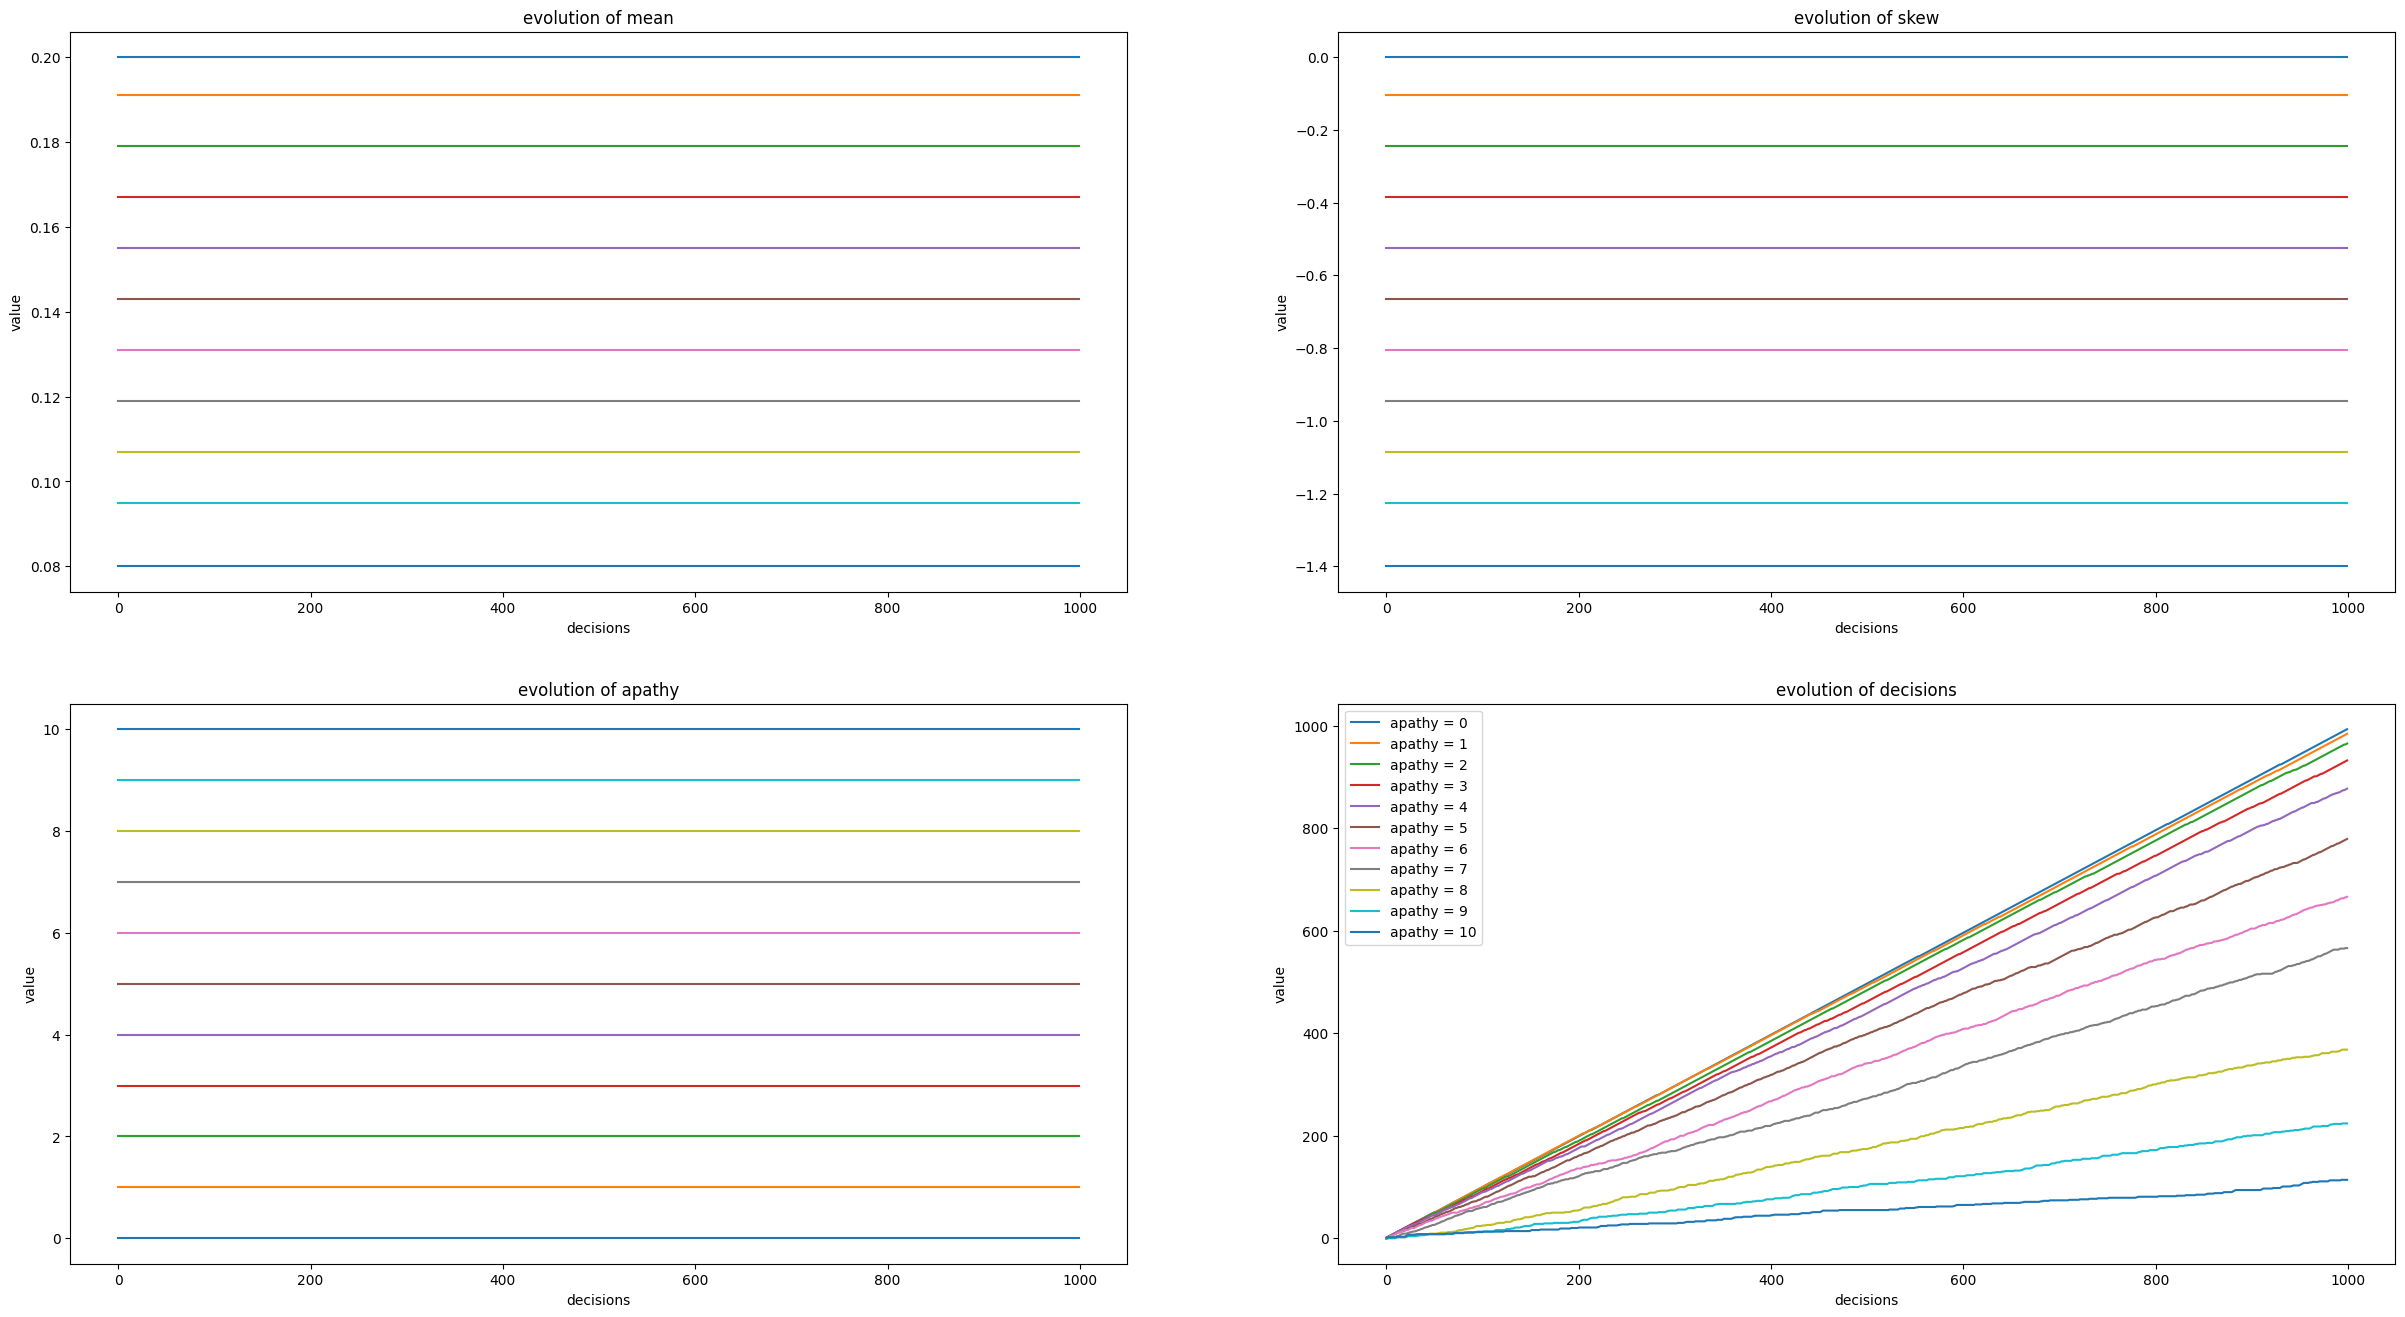

In [172]:

plt.rcParams["figure.figsize"] = (30, 16)
fig, axs = plt.subplots(2, 2)
x = np.arange(0,100*10)
for ax in axs.flat:
    ax.set(xlabel='decisions', ylabel='value')


for i in range(0,11):

    ap = i

    out = learn_sim_ap(ap , 100, pos_th, neg_th, en_th, var, var_no )
    y1 = out[0]
    y2 = out[1]
    y3 = out[2]
    y4 = out[3]
    axs[0, 0].plot(x, y1,label = 'apathy = %d' %(ap))
    axs[0, 0].set_title('evolution of mean')
    axs[0, 1].plot(x, y2,label = 'apathy = %d' %(ap))
    axs[0, 1].set_title('evolution of skew')
    axs[1, 0].plot(x, y3,label = 'apathy = %d' %(ap))
    axs[1, 0].set_title('evolution of apathy')
    axs[1, 1].plot(x, y4,label = 'apathy = %d' %(ap))
    axs[1, 1].set_title('evolution of decisions')
plt.legend()

produce more plots, check specific apathys in more details, maybe plots that show changing variables and the effect in order to justify specific numbers, also make a plot that shows the impact of energy over time (energy per decision, energy usgae in a day, daily exhaustions, decisions not made), could also produce a plot of times taken to make a decision (deliberation time)

Graphs ar enot looking good, need to check the model for errors and tweak is there arent any
Look at what specific parts of the model are doing in more detail
Inital settings are find for each apathy, issue must be in learning or daily exhaust
daily exhasut is creating strange flucuations at low apathy (there were small flucuations for no daily en_th but they were ignoreable)

2.592
179


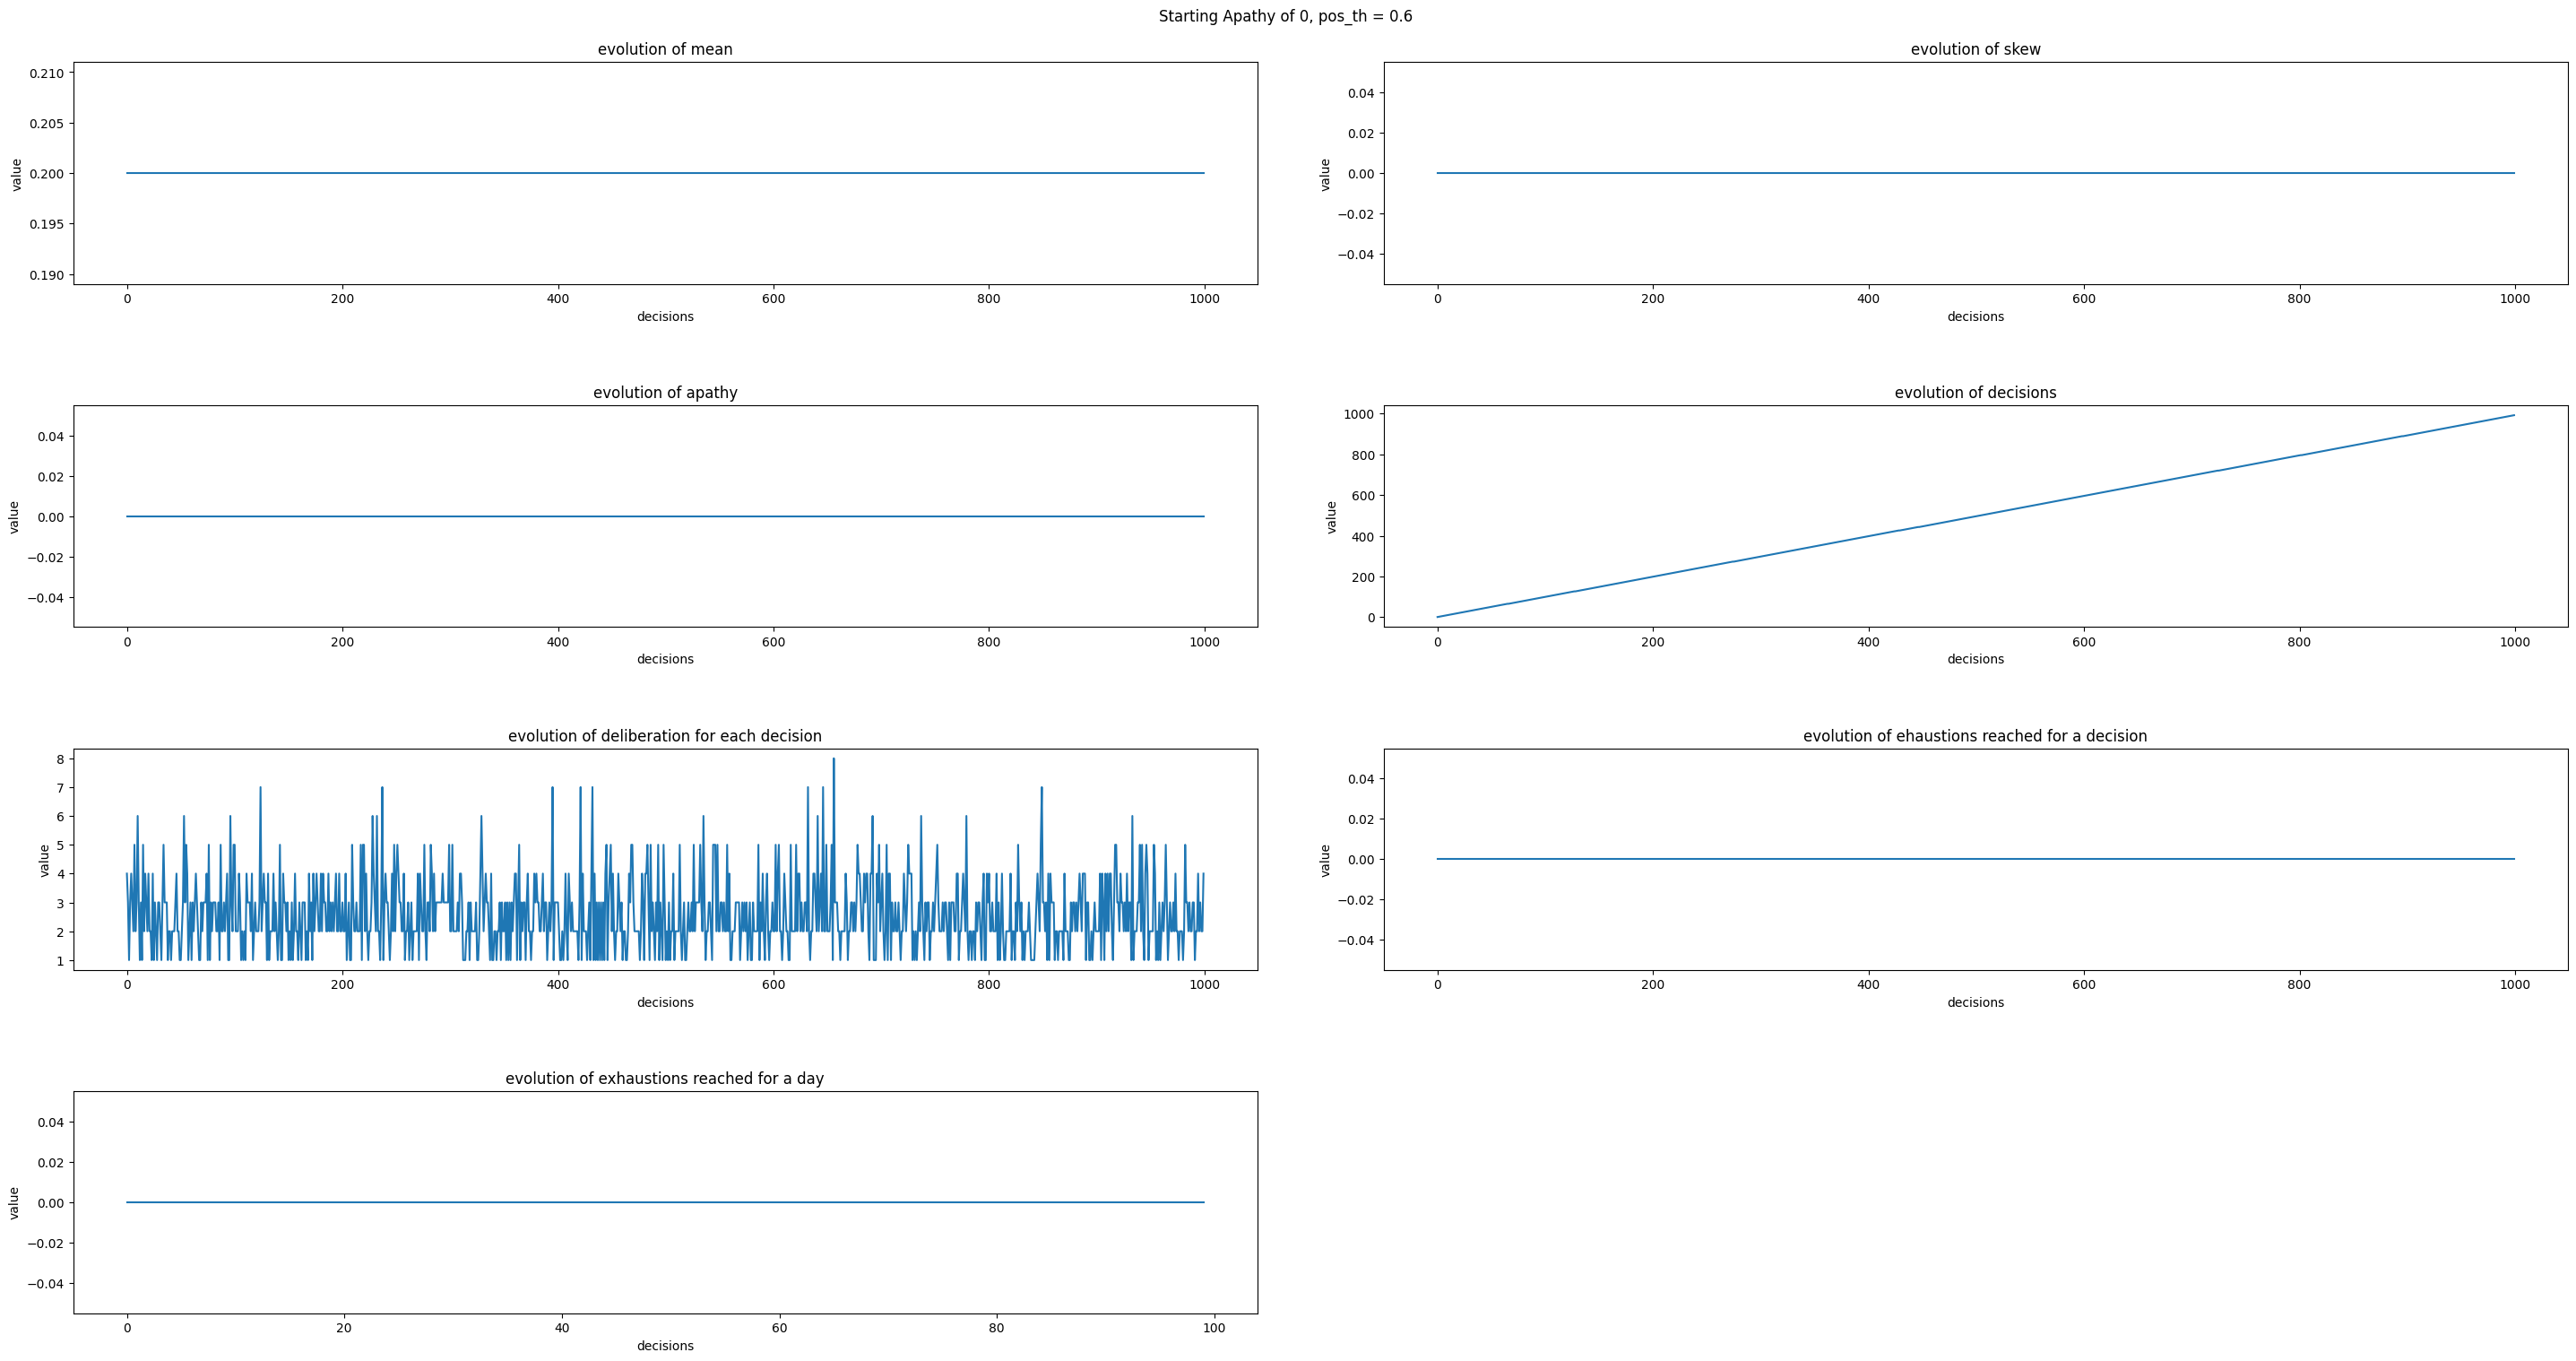

In [173]:
days = 100

var,var_no  =0.2,0.1

plt.rcParams["figure.figsize"] = (30, 16)
fig, axs = plt.subplots(4, 2)
x = np.arange(0,days*10)
x2 = np.arange(0,days)
for ax in axs.flat:
    ax.set(xlabel='decisions', ylabel='value')


ap = 0

out = learn_sim_ap(ap , days, pos_th, neg_th, en_th, var, var_no )
y1 = out[0]
y2 = out[1]
y3 = out[2]
y4 = out[3]
y5 = out[4]
x5 = np.arange(0,len(y5))
y6 = out[5]
y7 = out[6]
axs[0, 0].plot(x, y1)
axs[0, 0].set_title('evolution of mean')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title('evolution of skew')
axs[1, 0].plot(x, y3)
axs[1, 0].set_title('evolution of apathy')
axs[1, 1].plot(x, y4)
axs[1, 1].set_title('evolution of decisions')
axs[2, 0].plot(x5, y5)
axs[2, 0].set_title('evolution of deliberation for each decision')
axs[2, 1].plot(x, y6)
axs[2, 1].set_title('evolution of ehaustions reached for a decision')
axs[3, 0].plot(x2, y7)
axs[3, 0].set_title('evolution of exhaustions reached for a day')
fig.delaxes(axs[3,1])
fig.tight_layout(pad=5.0)
fig.suptitle('Starting Apathy of 0, pos_th = 0.6')
print(np.average(y5))
count=0
for i in y5:
    if i ==1:
        count+=1
print(count)



3.472


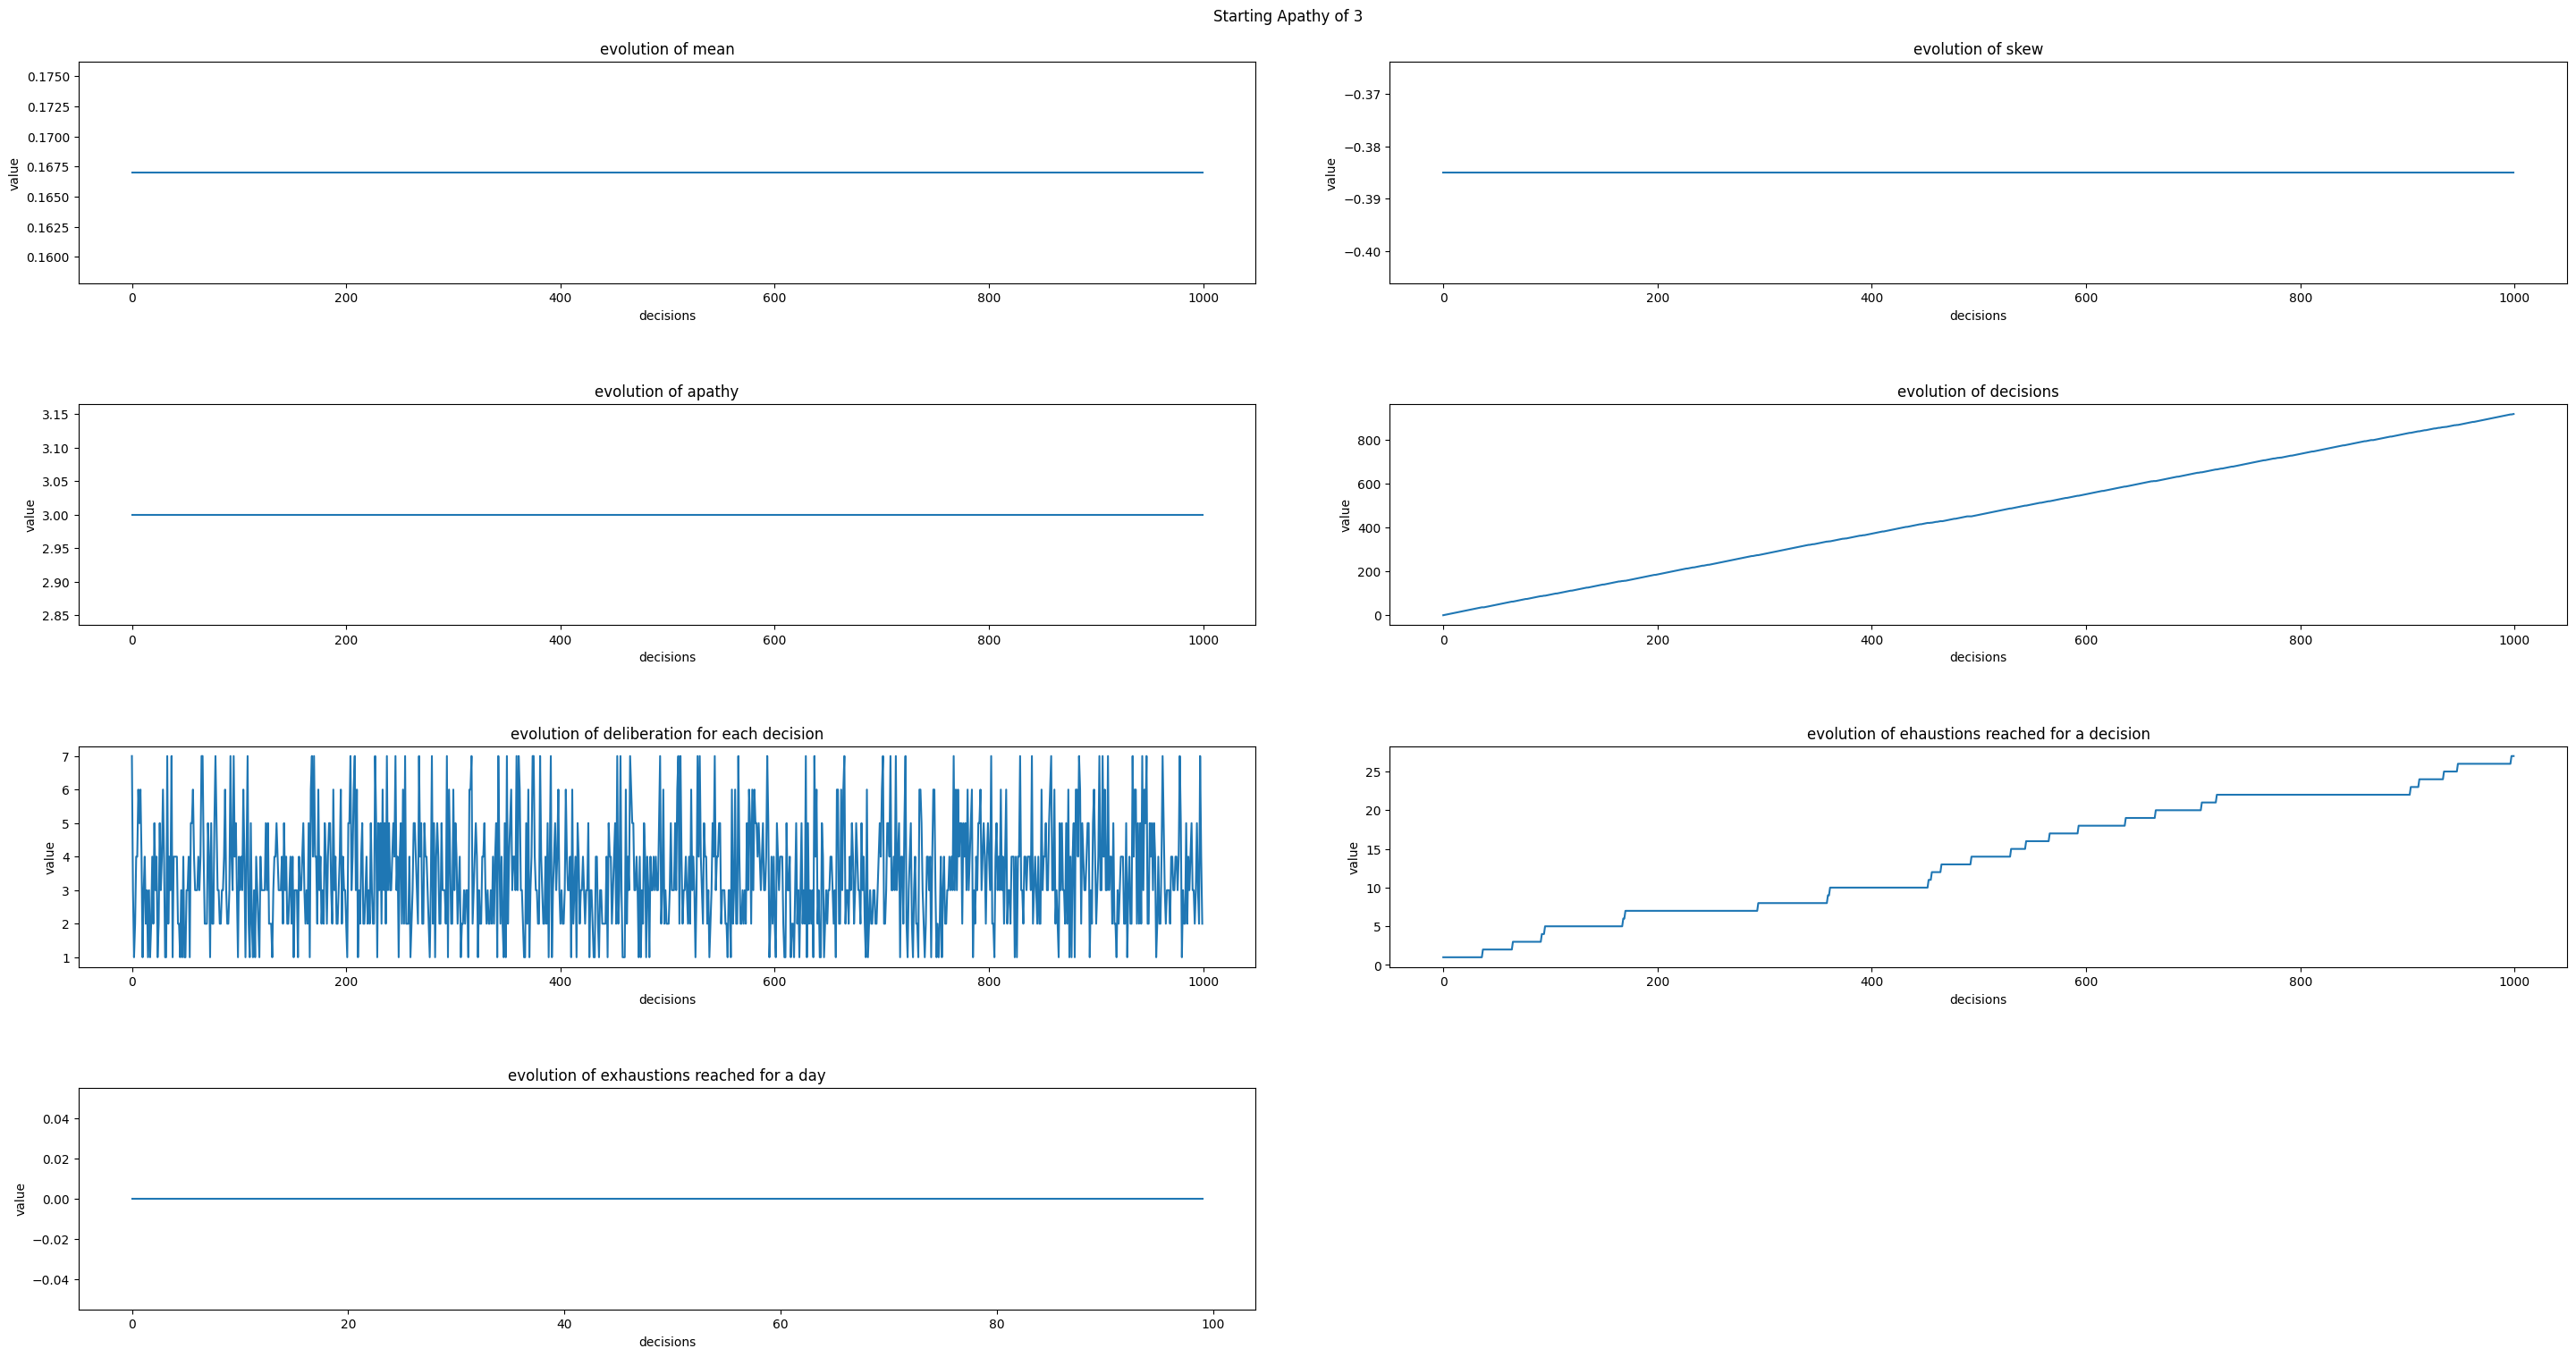

In [174]:

var,var_no  =0.2,0.1

plt.rcParams["figure.figsize"] = (30, 16)
fig, axs = plt.subplots(4, 2)
x = np.arange(0,100*10)
x2 = np.arange(0,100)
for ax in axs.flat:
    ax.set(xlabel='decisions', ylabel='value')


ap = 3

out = learn_sim_ap(ap , 100, pos_th, neg_th, en_th, var, var_no )
y1 = out[0]
y2 = out[1]
y3 = out[2]
y4 = out[3]
y5 = out[4]
x5 = np.arange(0,len(y5))
y6 = out[5]
y7 = out[6]
axs[0, 0].plot(x, y1)
axs[0, 0].set_title('evolution of mean')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title('evolution of skew')
axs[1, 0].plot(x, y3)
axs[1, 0].set_title('evolution of apathy')
axs[1, 1].plot(x, y4)
axs[1, 1].set_title('evolution of decisions')
axs[2, 0].plot(x5, y5)
axs[2, 0].set_title('evolution of deliberation for each decision')
axs[2, 1].plot(x, y6)
axs[2, 1].set_title('evolution of ehaustions reached for a decision')
axs[3, 0].plot(x2, y7)
axs[3, 0].set_title('evolution of exhaustions reached for a day')
fig.delaxes(axs[3,1])
fig.tight_layout(pad=5.0)
fig.suptitle('Starting Apathy of 3')
print(np.average(y5))


4.2472361809045225


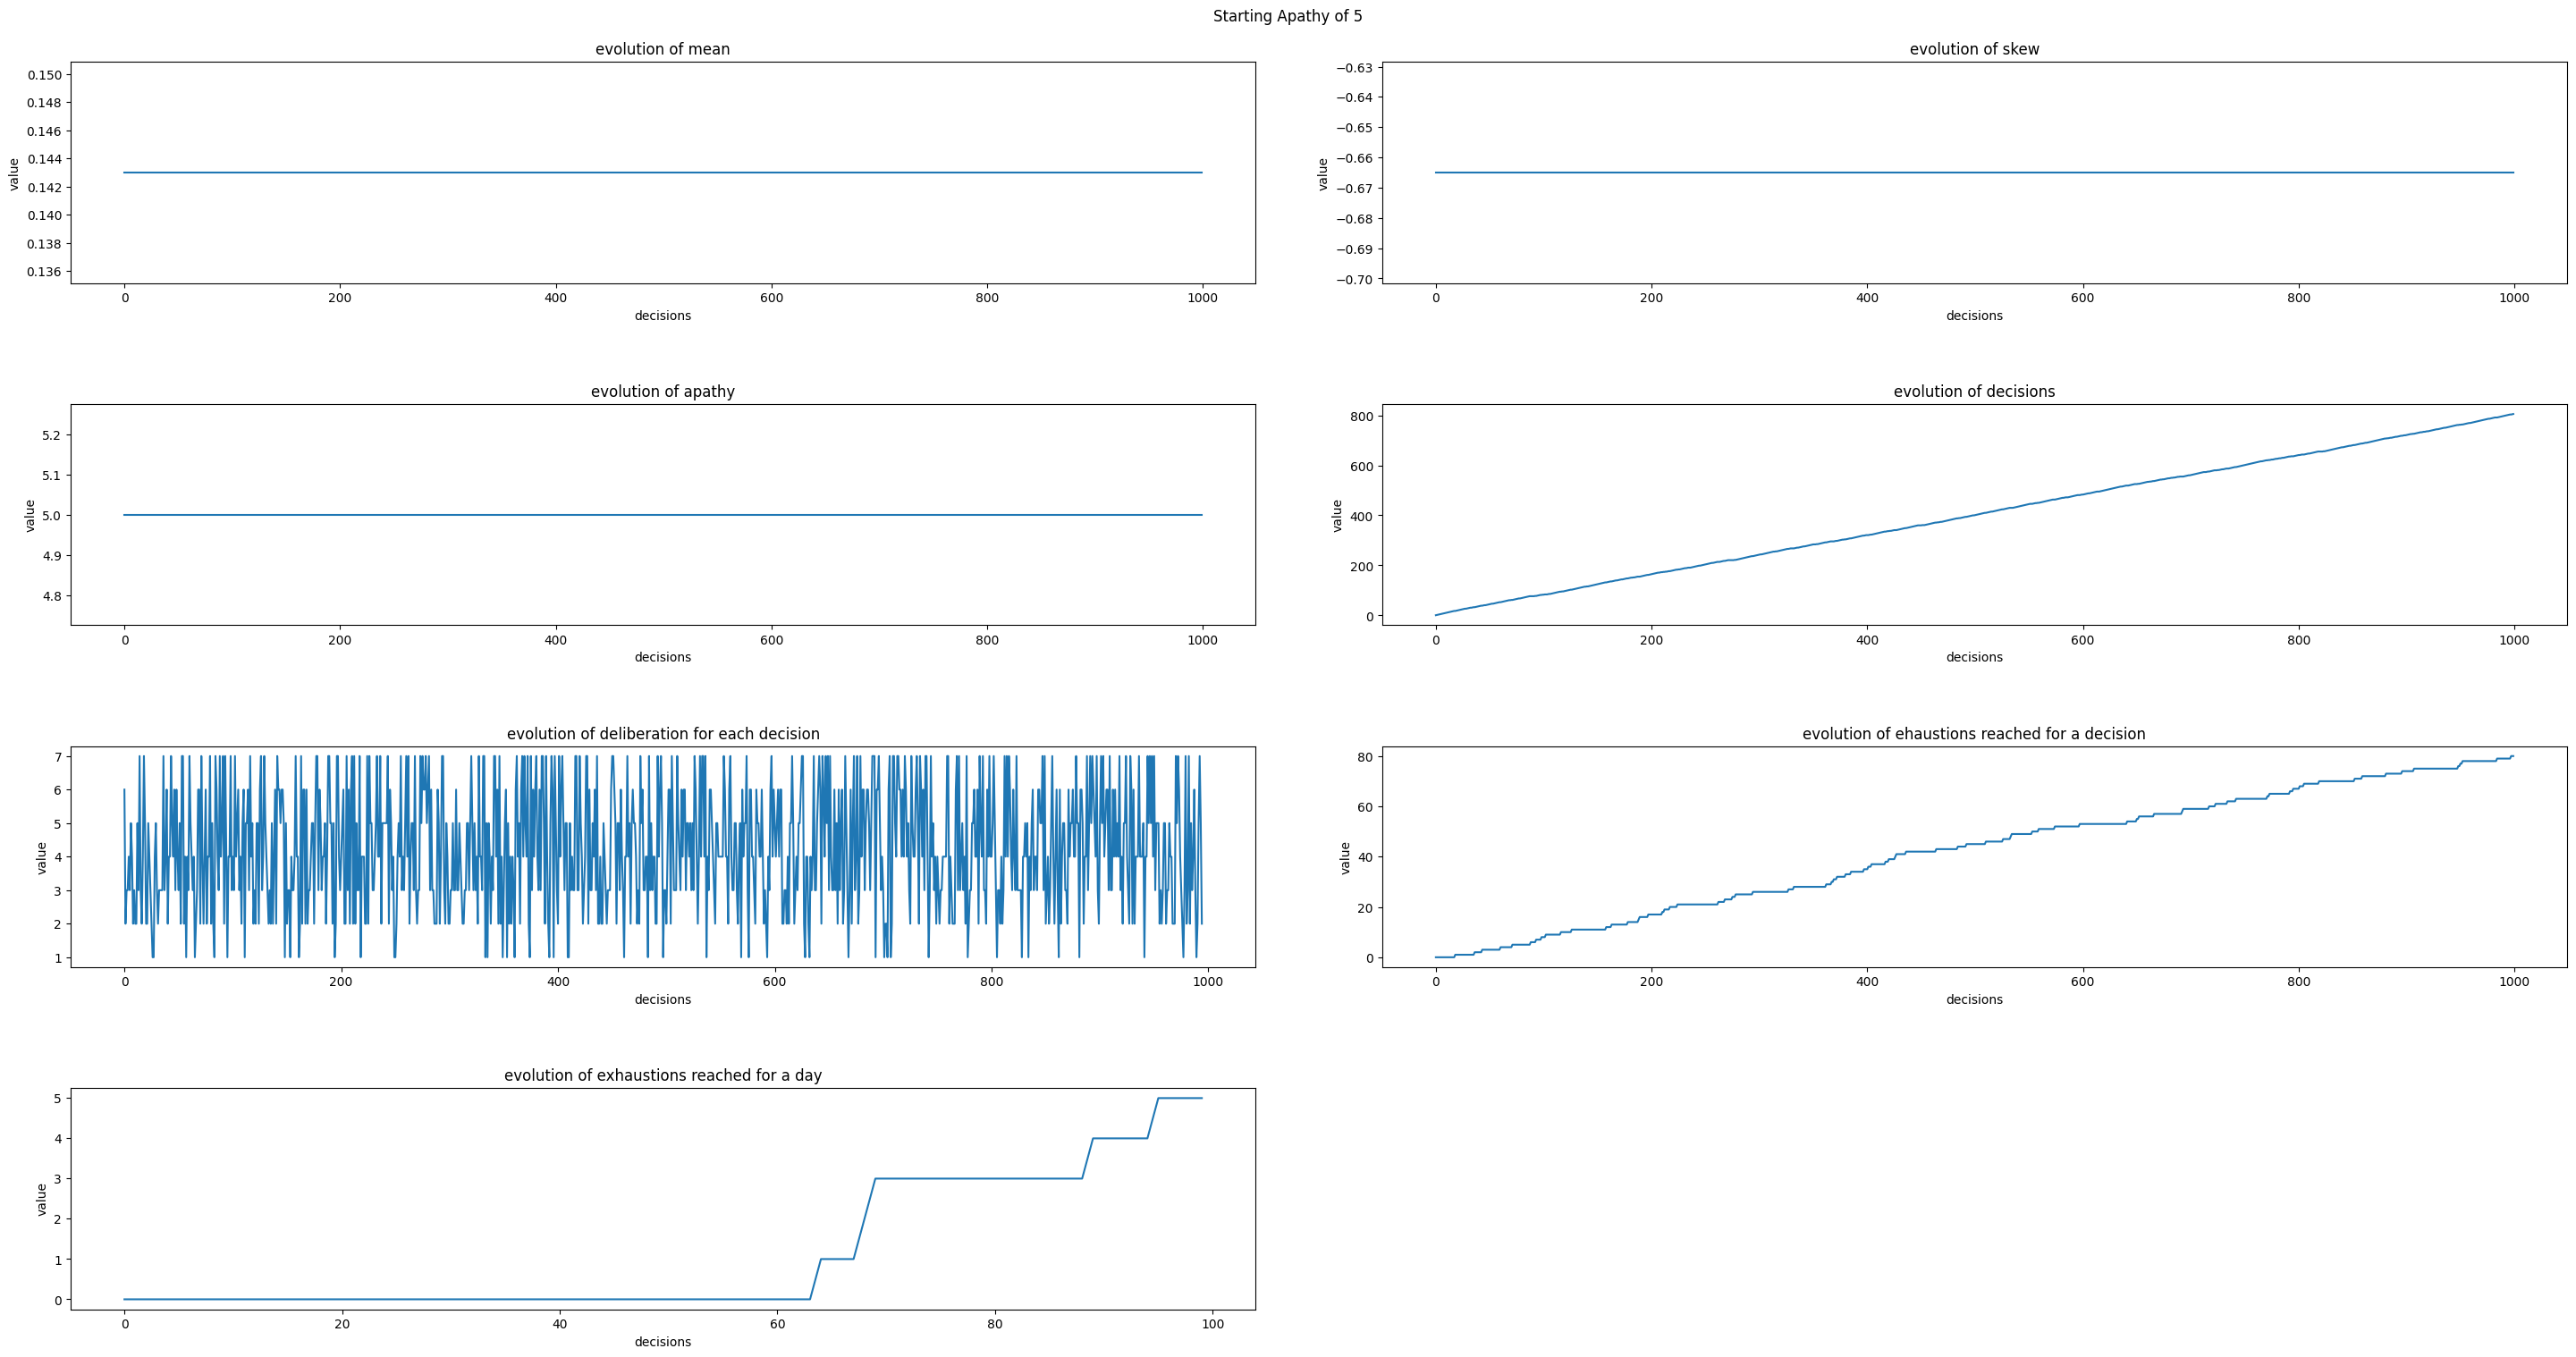

In [175]:

var,var_no  =0.2,0.1

plt.rcParams["figure.figsize"] = (30, 16)
fig, axs = plt.subplots(4, 2)
x = np.arange(0,100*10)
x2 = np.arange(0,100)
for ax in axs.flat:
    ax.set(xlabel='decisions', ylabel='value')


ap = 5

out = learn_sim_ap(ap , 100, pos_th, neg_th, en_th, var, var_no )
y1 = out[0]
y2 = out[1]
y3 = out[2]
y4 = out[3]
y5 = out[4]
x5 = np.arange(0,len(y5))
y6 = out[5]
y7 = out[6]
axs[0, 0].plot(x, y1)
axs[0, 0].set_title('evolution of mean')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title('evolution of skew')
axs[1, 0].plot(x, y3)
axs[1, 0].set_title('evolution of apathy')
axs[1, 1].plot(x, y4)
axs[1, 1].set_title('evolution of decisions')
axs[2, 0].plot(x5, y5)
axs[2, 0].set_title('evolution of deliberation for each decision')
axs[2, 1].plot(x, y6)
axs[2, 1].set_title('evolution of ehaustions reached for a decision')
axs[3, 0].plot(x2, y7)
axs[3, 0].set_title('evolution of exhaustions reached for a day')
fig.delaxes(axs[3,1])
fig.tight_layout(pad=5.0)
fig.suptitle('Starting Apathy of 5')
print(np.average(y5))

4.862745098039215


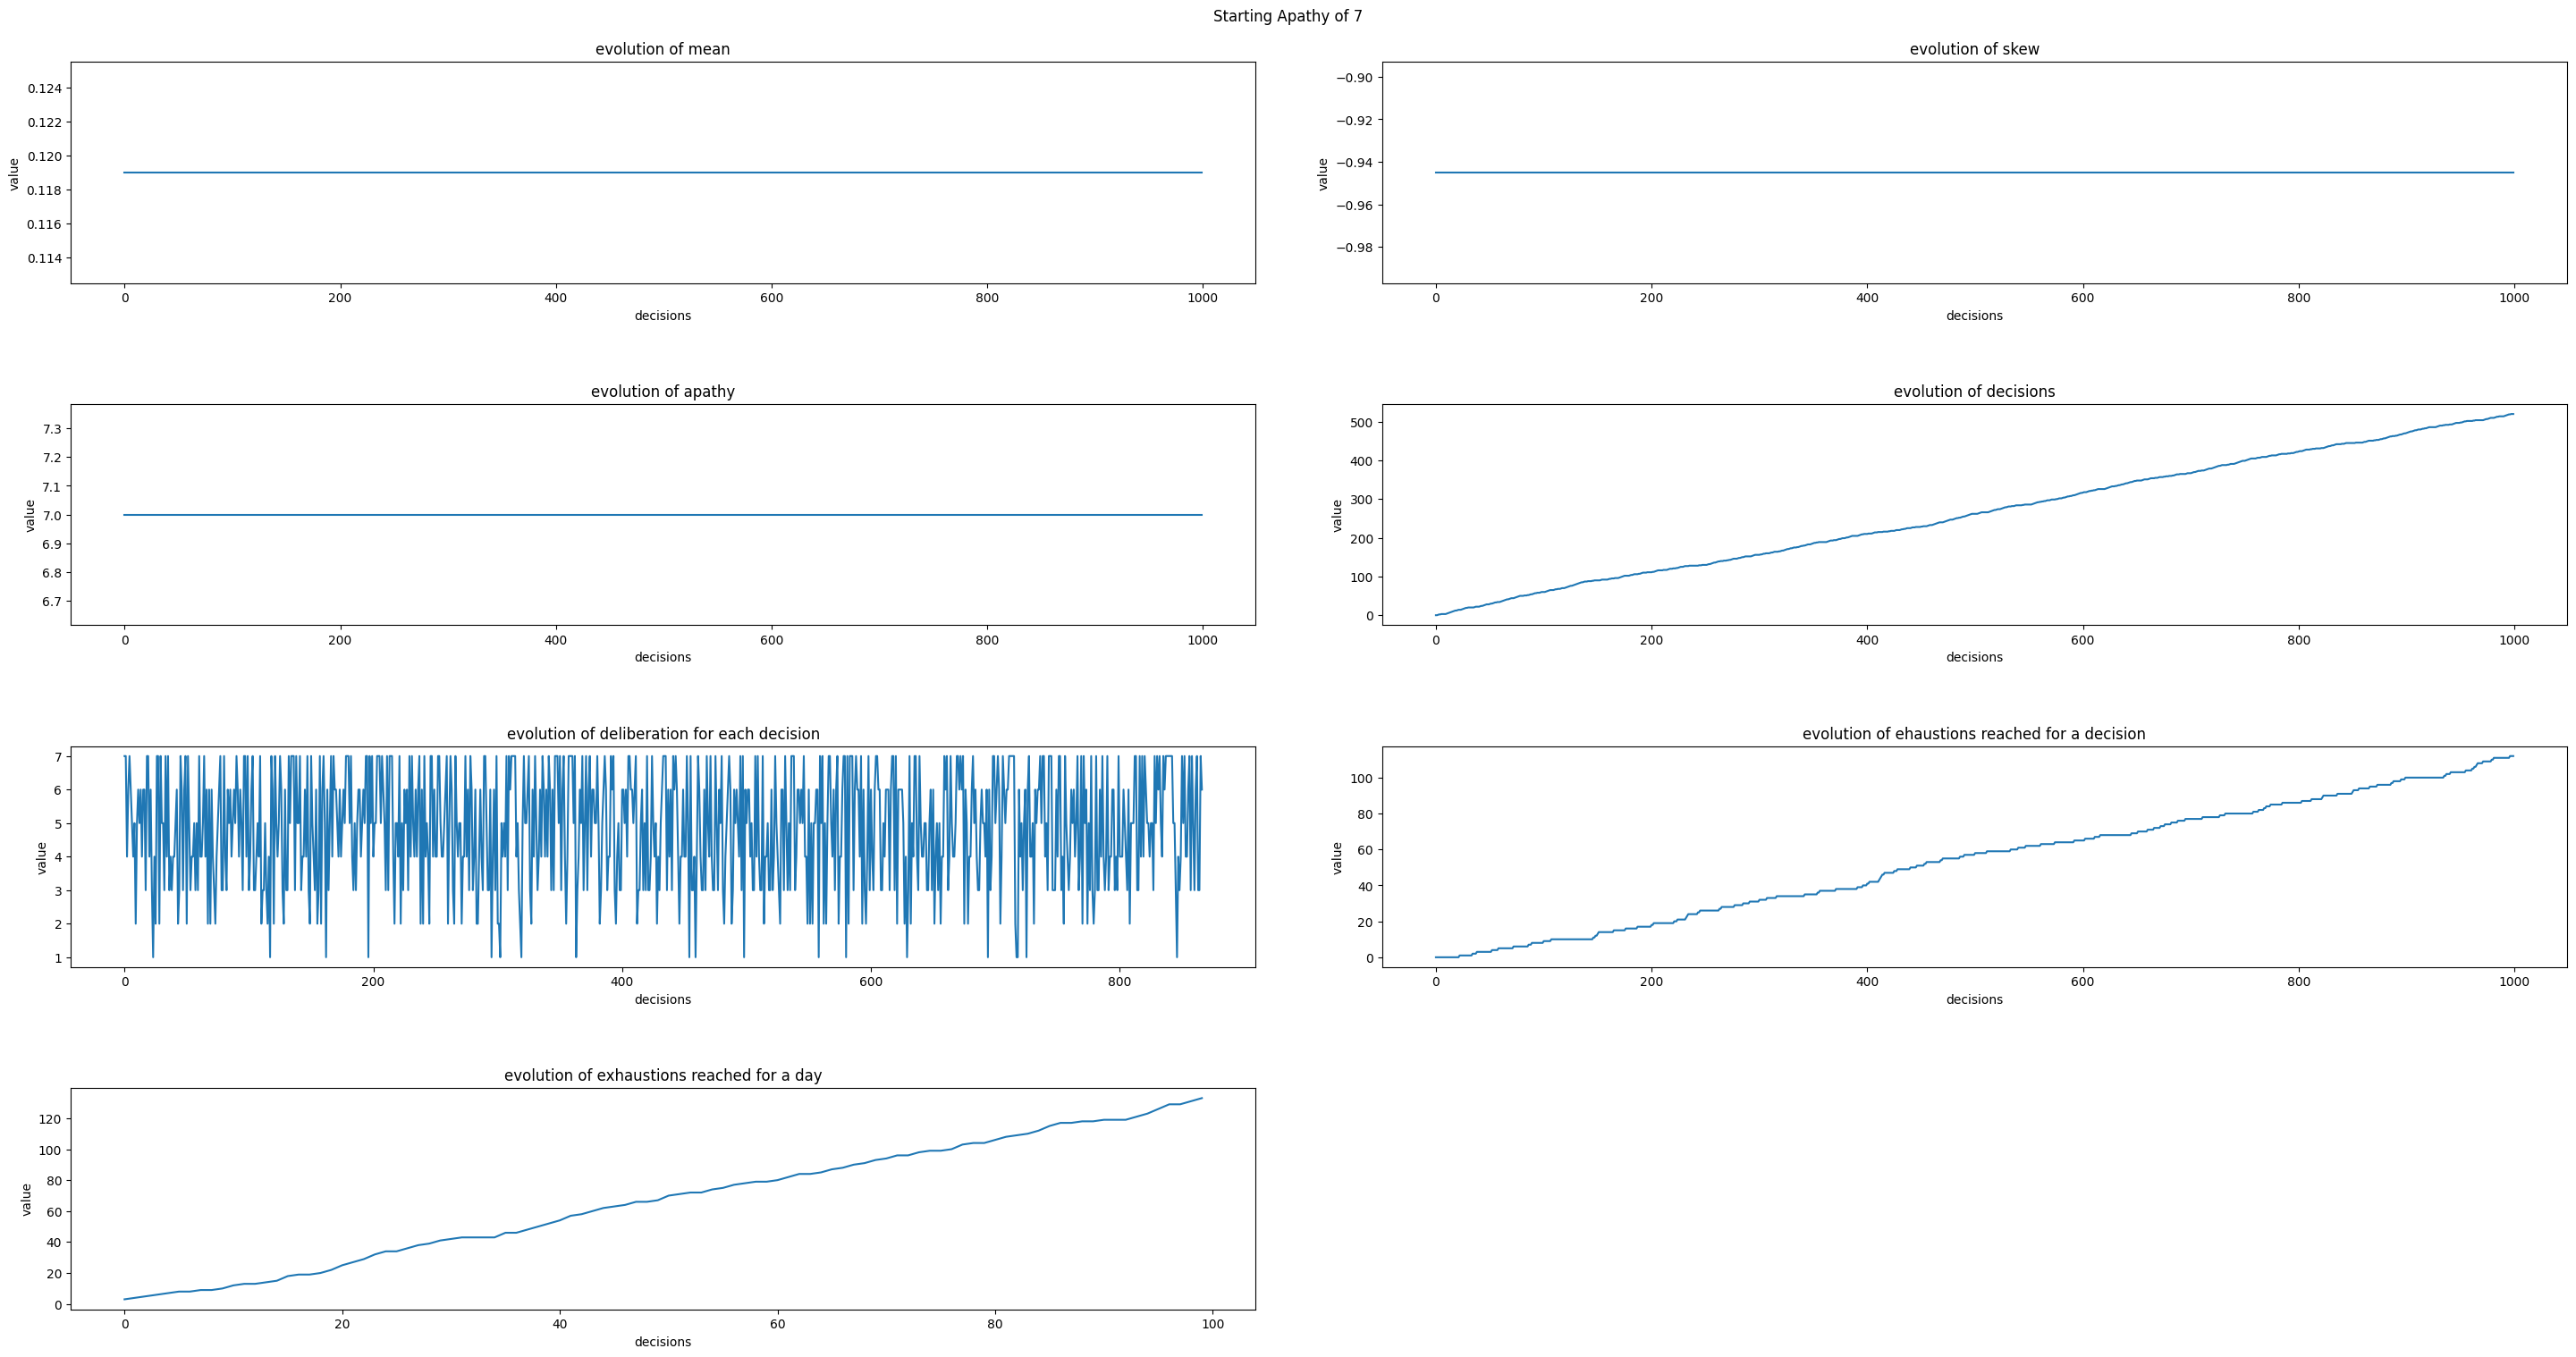

In [176]:

var,var_no  =0.2,0.1

plt.rcParams["figure.figsize"] = (30, 16)
fig, axs = plt.subplots(4, 2)
x = np.arange(0,100*10)
x2 = np.arange(0,100)
for ax in axs.flat:
    ax.set(xlabel='decisions', ylabel='value')


ap = 7

out = learn_sim_ap(ap , 100, pos_th, neg_th, en_th, var, var_no )
y1 = out[0]
y2 = out[1]
y3 = out[2]
y4 = out[3]
y5 = out[4]
x5 = np.arange(0,len(y5))
y6 = out[5]
y7 = out[6]
axs[0, 0].plot(x, y1)
axs[0, 0].set_title('evolution of mean')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title('evolution of skew')
axs[1, 0].plot(x, y3)
axs[1, 0].set_title('evolution of apathy')
axs[1, 1].plot(x, y4)
axs[1, 1].set_title('evolution of decisions')
axs[2, 0].plot(x5, y5)
axs[2, 0].set_title('evolution of deliberation for each decision')
axs[2, 1].plot(x, y6)
axs[2, 1].set_title('evolution of ehaustions reached for a decision')
axs[3, 0].plot(x2, y7)
axs[3, 0].set_title('evolution of exhaustions reached for a day')
fig.delaxes(axs[3,1])
fig.tight_layout(pad=5.0)
fig.suptitle('Starting Apathy of 7')
print(np.average(y5))

5.149200710479573


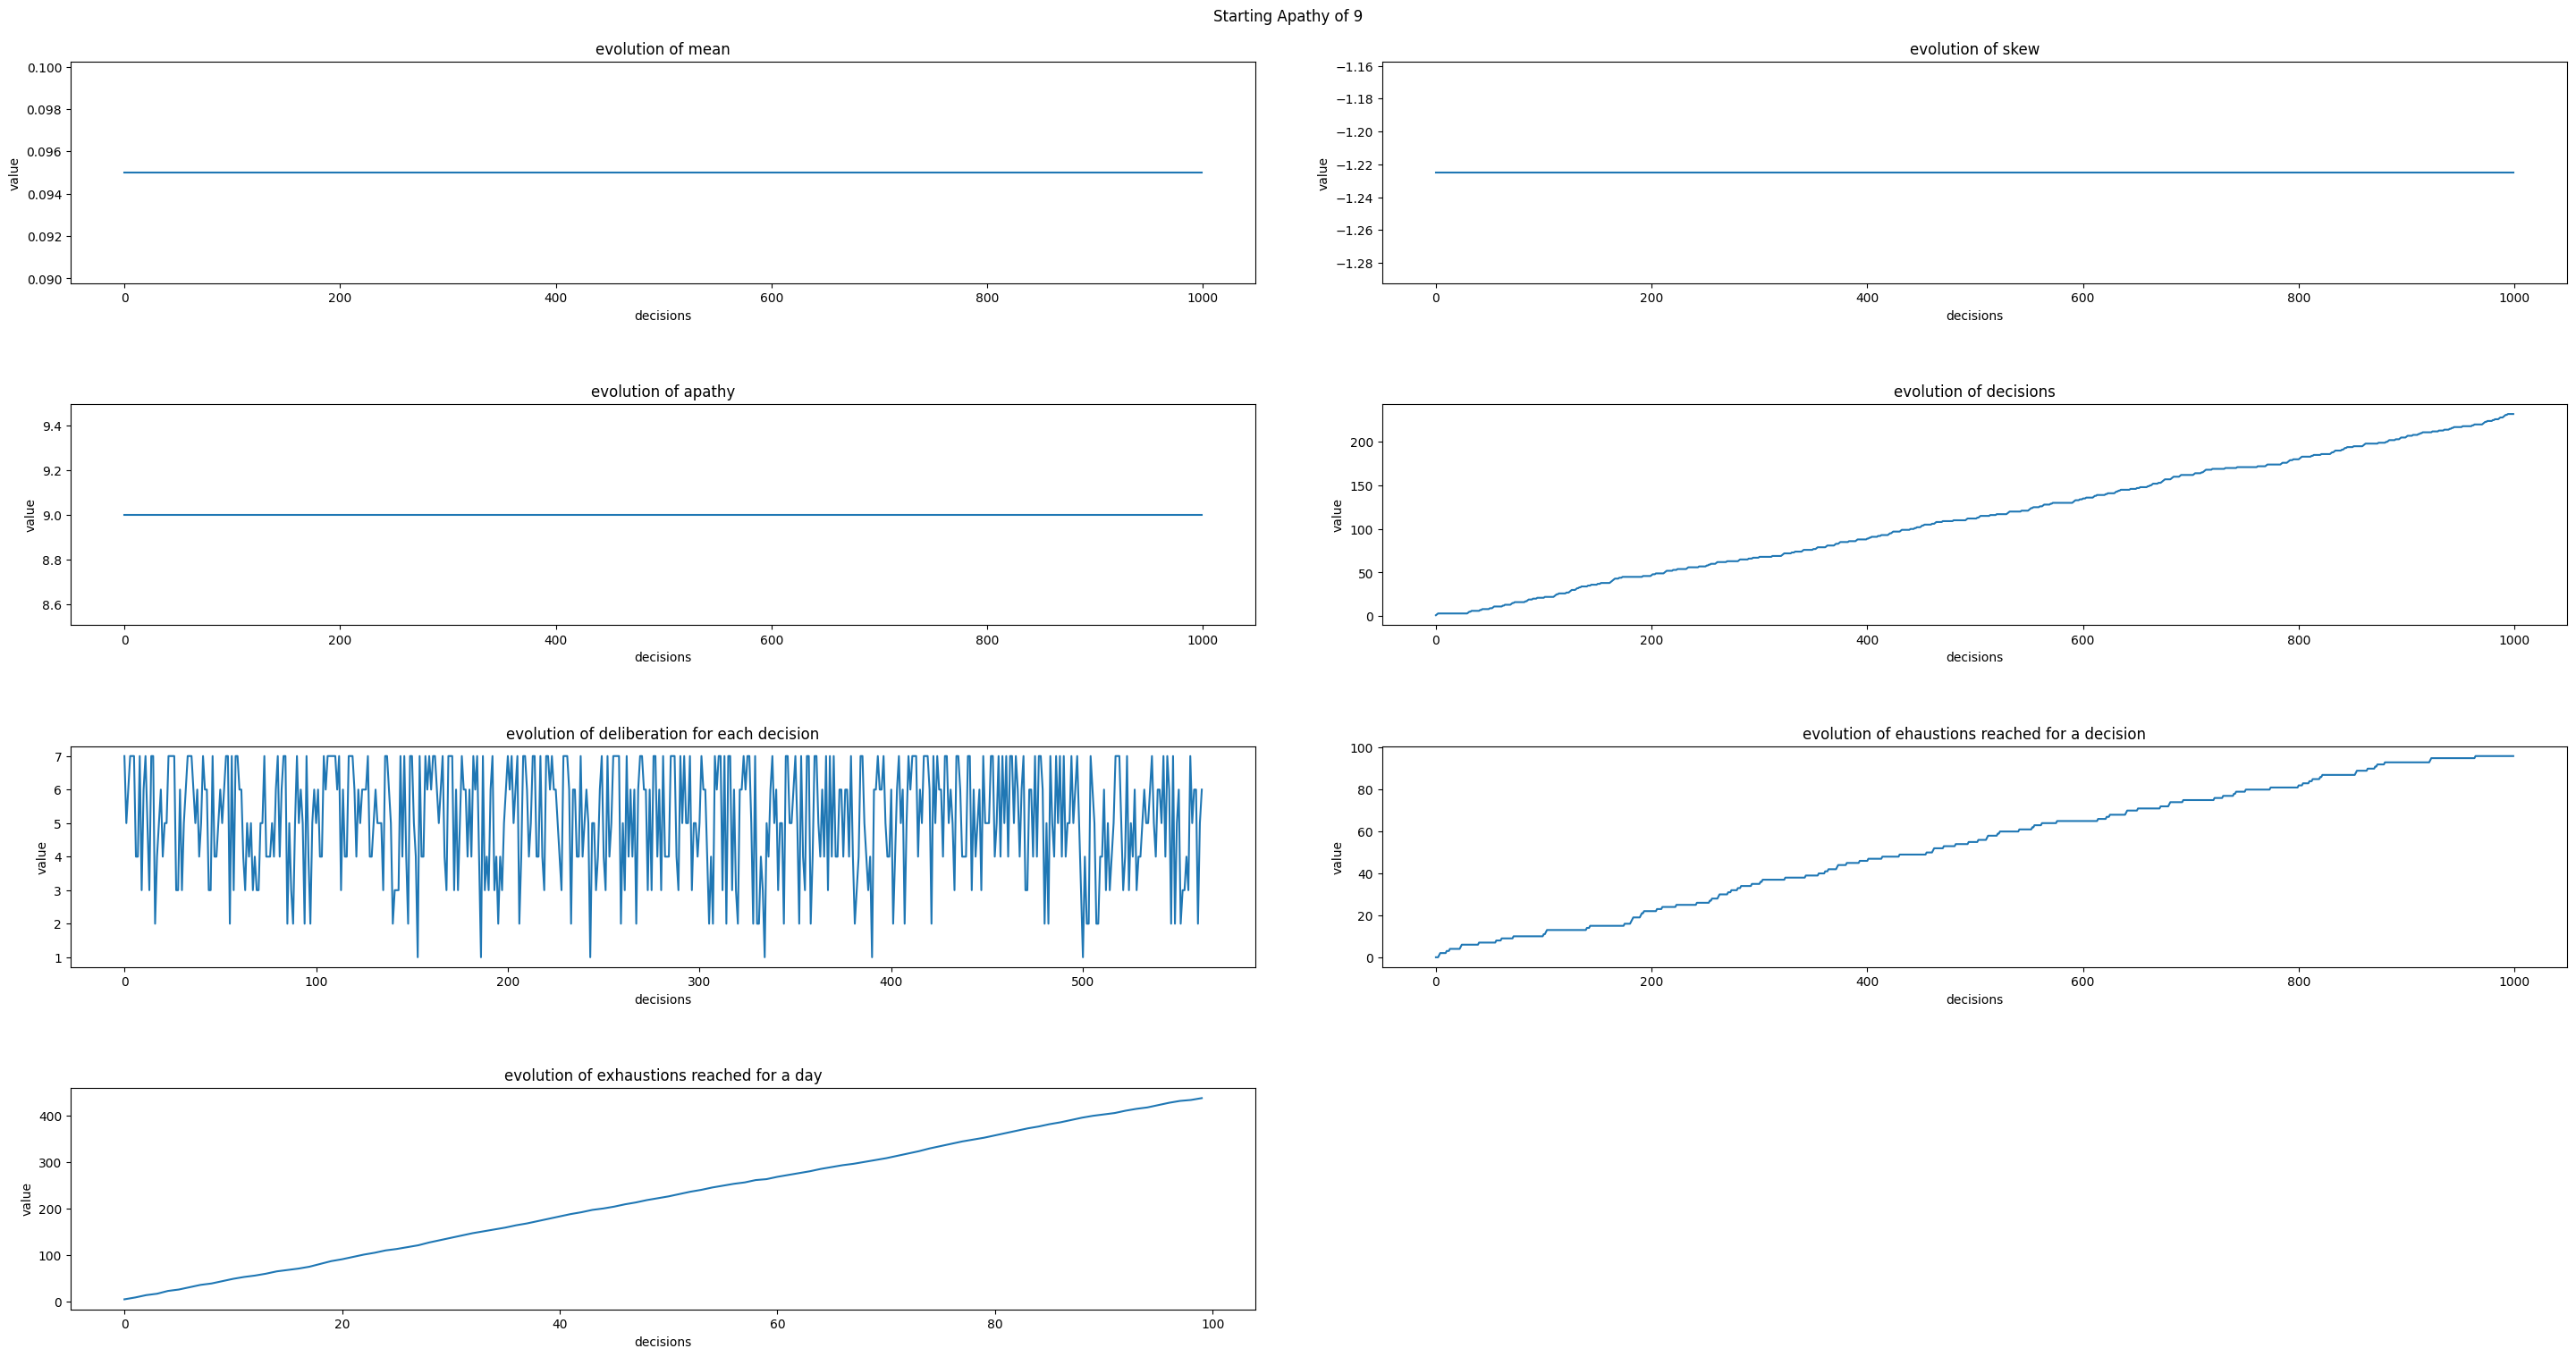

In [177]:

var,var_no  =0.2,0.1

plt.rcParams["figure.figsize"] = (30, 16)
fig, axs = plt.subplots(4, 2)
x = np.arange(0,100*10)
x2 = np.arange(0,100)
for ax in axs.flat:
    ax.set(xlabel='decisions', ylabel='value')


ap = 9

out = learn_sim_ap(ap , 100, pos_th, neg_th, en_th, var, var_no )
y1 = out[0]
y2 = out[1]
y3 = out[2]
y4 = out[3]
y5 = out[4]
x5 = np.arange(0,len(y5))
y6 = out[5]
y7 = out[6]
axs[0, 0].plot(x, y1)
axs[0, 0].set_title('evolution of mean')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title('evolution of skew')
axs[1, 0].plot(x, y3)
axs[1, 0].set_title('evolution of apathy')
axs[1, 1].plot(x, y4)
axs[1, 1].set_title('evolution of decisions')
axs[2, 0].plot(x5, y5)
axs[2, 0].set_title('evolution of deliberation for each decision')
axs[2, 1].plot(x, y6)
axs[2, 1].set_title('evolution of ehaustions reached for a decision')
axs[3, 0].plot(x2, y7)
axs[3, 0].set_title('evolution of exhaustions reached for a day')
fig.delaxes(axs[3,1])
fig.tight_layout(pad=5.0)
fig.suptitle('Starting Apathy of 9')
print(np.average(y5))

In [178]:
for i in range(0,11):
    out = initial(i,mean_interval,skew_interval,mean_overlap,skew_overlap)
    mn = out[0]
    sk = out[1]
    arr = []
    arr_2 = []
    tests = 10000
    for _ in range(tests):
        yes = stats.skewnorm.rvs(sk,mn,var)
        no = np.random.normal(0,var_no)
        if yes>no:
            arr.append(yes-no)
        if no>yes:
            arr_2.append(no-yes)
    print([i,np.average(arr),len(arr)/10000,np.average(arr_2),len(arr_2)/10000,mn,sk])

[0, 0.27226835748047384, 0.8122, 0.12159575471543418, 0.1878, 0.2, 0.0]
[1, 0.2556791302114396, 0.7862, 0.12531574613988974, 0.2138, 0.191, -0.10500000000000001]
[2, 0.2376843582530093, 0.7437, 0.13269311236553585, 0.2563, 0.179, -0.24500000000000002]
[3, 0.22158727562115235, 0.6896, 0.13519883780116326, 0.3104, 0.167, -0.385]
[4, 0.19998554021128948, 0.6446, 0.14084616381228057, 0.3554, 0.155, -0.525]
[5, 0.18468177098328994, 0.5994, 0.14634570381307382, 0.4006, 0.14300000000000002, -0.665]
[6, 0.17031522169213667, 0.5619, 0.15420331763368464, 0.4381, 0.131, -0.805]
[7, 0.15850853549505095, 0.5206, 0.15260160588189806, 0.4794, 0.119, -0.9450000000000001]
[8, 0.14542634493638432, 0.4816, 0.15801222170087167, 0.5184, 0.107, -1.0850000000000002]
[9, 0.13645018870007436, 0.4476, 0.16183981954256832, 0.5524, 0.095, -1.2249999999999999]
[10, 0.12347947870638176, 0.4024, 0.16907150789514874, 0.5976, 0.08, -1.4]
